In [1]:
import numpy as np
import awkward as ak
import uproot
import os
import time

from matplotlib import pyplot as plt
import hist
from hist import Hist

from coffea.nanoevents import NanoAODSchema, NanoEventsFactory

In [2]:
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Palatino"],
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        "legend.numpoints": 1,
        "axes.linewidth": 2,
        "legend.title_fontsize": 16,
        "axes.labelsize": 18,
        "legend.fontsize": 16,
    }
)

ptbins = [
    5,
    10,
    12.5,
    15,
    17.5,
    20,
    22.5,
    25,
    30,
    35,
    40,
    45,
    50,
    60,
    80,
    100,
    150,
    200,
    250,
    300,
    350,
    400,
]
etabins = [
    -2.5,
    -2.4,
    -2.3,
    -2.2,
    -2.1,
    -2.0,
    -1.9,
    -1.8,
    -1.7,
    -1.566,
    -1.4442,
    -1.3,
    -1.2,
    -1.1,
    -1.0,
    -0.9,
    -0.8,
    -0.7,
    -0.6,
    -0.5,
    -0.4,
    -0.3,
    -0.2,
    -0.1,
    0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    1,
    1.1,
    1.2,
    1.3,
    1.4442,
    1.566,
    1.7,
    1.8,
    1.9,
    2.0,
    2.1,
    2.2,
    2.3,
    2.4,
    2.5,
]

In [3]:
%%time
fname = "root_files/Egamma1.root"
events = NanoEventsFactory.from_root(
    {os.path.abspath(fname): "Events"},
    schemaclass=NanoAODSchema.v6,
    metadata={"dataset": "Egamma"},
).events()

print(len(events))

608140
CPU times: user 47.3 s, sys: 743 ms, total: 48.1 s
Wall time: 45.8 s


In [4]:
def filter_events(events):
    events = events[ak.num(events.Electron) >= 2]
    abs_eta = abs(events.Electron.eta)
    pass_eta_ebeegap = (abs_eta < 1.4442) | (abs_eta > 1.566)
    pass_tight_id = events.Electron.cutBased == 4
    pass_pt = events.Electron.pt > 31
    pass_eta = abs_eta <= 2.5
    pass_selection = pass_pt & pass_eta & pass_eta_ebeegap & pass_tight_id
    n_of_tags = ak.sum(pass_selection, axis=1)
    good_events = events[n_of_tags >= 2]
    good_locations = pass_selection[n_of_tags >= 2]

    return good_events, good_locations


def trigger_match(electrons, trigobjs):
    pass_pt = trigobjs.pt > 31
    pass_id = abs(trigobjs.id) == 11
    pass_wptight = trigobjs.filterBits & (0x1 << 1) == 2
    trigger_cands = trigobjs[pass_pt & pass_id & pass_wptight]

    nearest_match = electrons.nearest(trigger_cands, threshold=0.1)
    n_of_trigger_matches = ak.sum(nearest_match.eta != None, axis=1)
    trig_matched_locs = n_of_trigger_matches >= 1

    return trig_matched_locs


def perform_tnp(zcands, events):
    trig_matched_tag = trigger_match(zcands.tag, events.TrigObj)
    zcands = zcands[trig_matched_tag]
    events = events[trig_matched_tag]

    dr = zcands.tag.delta_r(zcands.probe)
    mass = (zcands.tag + zcands.probe).mass

    in_mass_window = abs(mass - 91.1876) < 30
    opposite_charge = zcands.tag.charge * zcands.probe.charge == -1

    isZ = in_mass_window & opposite_charge
    dr_condition = dr > 0.0

    all_probes = zcands.probe[isZ & dr_condition]
    trig_matched_probe = trigger_match(all_probes, events.TrigObj)
    passing_probes = all_probes[trig_matched_probe]

    return passing_probes, all_probes


def replace_nans(arr):
    arr = np.array(arr)

    # Find the index of first non-nan value
    first_float_index = np.where(~np.isnan(arr))[0][0]

    # Create masks for before and after the first float
    before_first_float = np.arange(len(arr)) < first_float_index
    after_first_float = ~before_first_float

    # Replace all nans with 0 before first float number and with 1 after
    arr[before_first_float & np.isnan(arr)] = 0
    arr[after_first_float & np.isnan(arr)] = 1

    return arr

In [5]:
start = time.perf_counter()

good_events, good_locations = filter_events(events)

ele_for_tnp = good_events.Electron[good_locations]
print(len(ele_for_tnp))

zcands1 = ak.combinations(ele_for_tnp, 2, fields=["tag", "probe"])
zcands2 = ak.combinations(ele_for_tnp, 2, fields=["probe", "tag"])
p1, a1 = perform_tnp(zcands1, good_events)
p2, a2 = perform_tnp(zcands2, good_events)

passing_probes = ak.concatenate([p1, p2])
all_probes = ak.concatenate([a1, a2])
print(len(ak.flatten(passing_probes)))
print(len(ak.flatten(all_probes)))

end = time.perf_counter()
print(end - start)

5455
7674
8947
0.28008154197596014


In [6]:
ptaxis = hist.axis.Variable(ptbins, name="pt")
hpt_all = Hist(ptaxis)
hpt_pass = Hist(ptaxis)

etaaxis = hist.axis.Variable(etabins, name="eta")
heta_all = Hist(etaaxis)
heta_pass = Hist(etaaxis)

absetaaxis = hist.axis.Variable(np.unique(np.abs(etabins)), name="abseta")
habseta_all = Hist(absetaaxis)
habseta_pass = Hist(absetaaxis)


hpt_all.fill(ak.flatten(all_probes.pt))
hpt_pass.fill(ak.flatten(passing_probes.pt))

heta_all.fill(ak.flatten(all_probes.eta))
heta_pass.fill(ak.flatten(passing_probes.eta))

habseta_all.fill(abs(ak.flatten(all_probes.eta)))
habseta_pass.fill(abs(ak.flatten(passing_probes.eta)))

hptratio = hpt_pass / hpt_all
hptratio[:] = replace_nans(hptratio.values())

hetaratio = habseta_pass / habseta_all
hetaratio[:] = replace_nans(hetaratio.values())

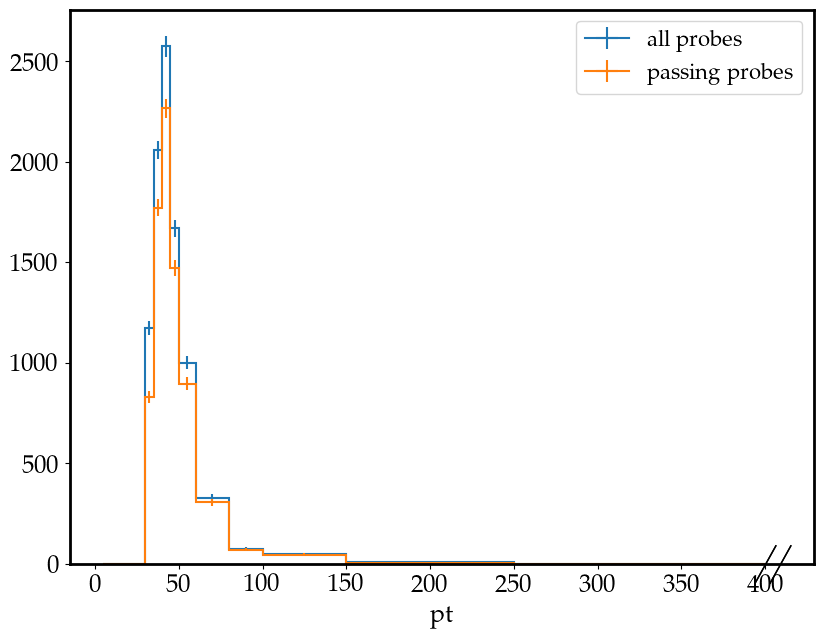

In [7]:
plt.figure(figsize=(6.4 * 1.5, 4.8 * 1.5))
hpt_all.plot1d(label="all probes")
hpt_pass.plot1d(label="passing probes")
plt.legend()
plt.savefig("plots/pt.pdf", bbox_inches="tight")
plt.show()

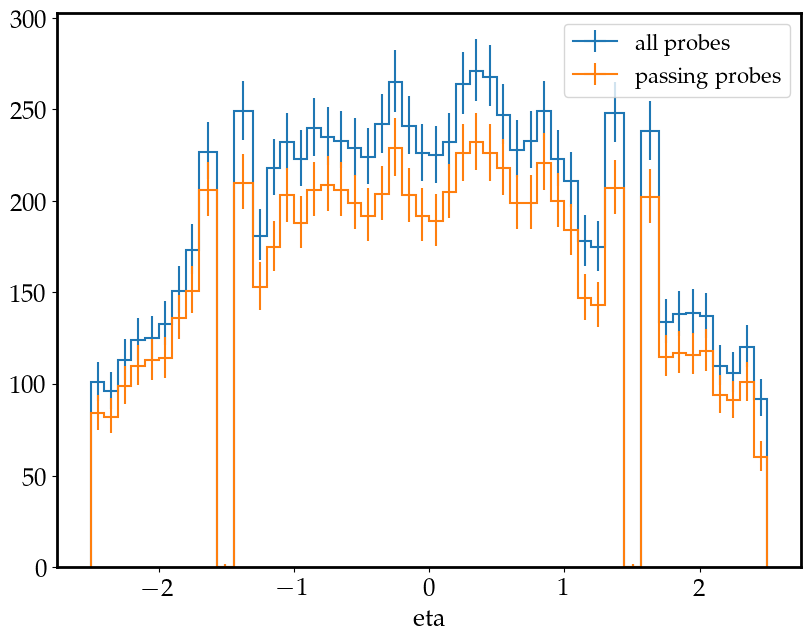

In [8]:
plt.figure(figsize=(6.4 * 1.5, 4.8 * 1.5))
heta_all.plot1d(label="all probes")
heta_pass.plot1d(label="passing probes")
plt.legend()
plt.savefig("plots/eta.pdf", bbox_inches="tight")
plt.show()

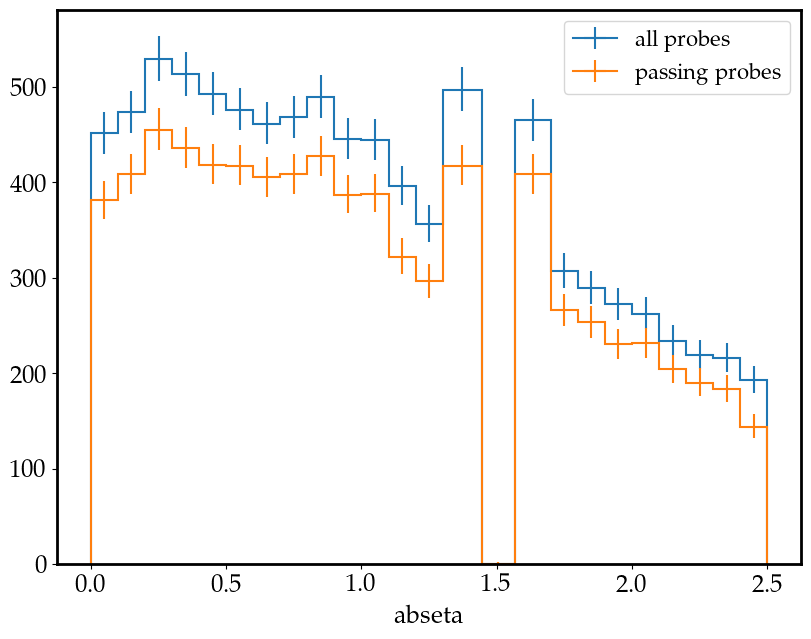

In [9]:
plt.figure(figsize=(6.4 * 1.5, 4.8 * 1.5))
habseta_all.plot1d(label="all probes")
habseta_pass.plot1d(label="passing probes")
plt.legend()
plt.savefig("plots/abseta.pdf", bbox_inches="tight")
plt.show()

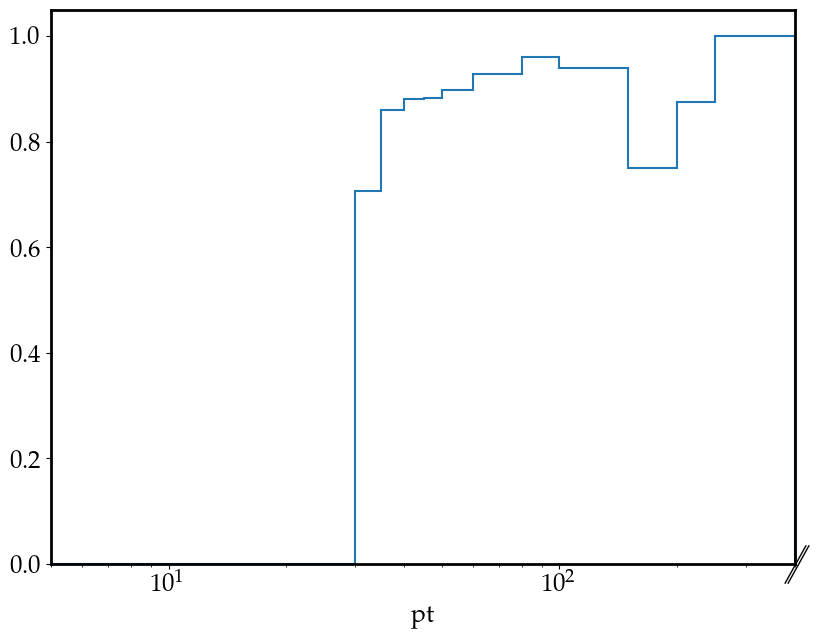

In [10]:
plt.figure(figsize=(6.4 * 1.5, 4.8 * 1.5))
hptratio.plot1d()
plt.xlim(5, 400)
plt.xscale("log")
plt.savefig("plots/eff_pt.pdf", bbox_inches="tight")
plt.show()

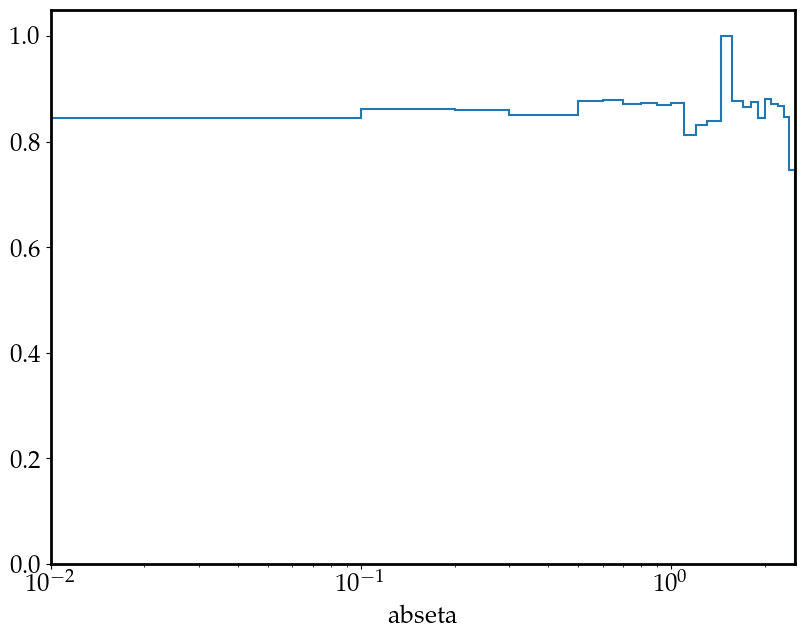

In [11]:
plt.figure(figsize=(6.4 * 1.5, 4.8 * 1.5))
hetaratio.plot1d()
plt.xlim(1e-2, 2.5)
plt.xscale("log")
plt.savefig("plots/eff_eta.pdf", bbox_inches="tight")
plt.show()